# Introduction

In this tutorial, we will explain the basics of using Data Detective to perform a Data Investigation. In this tutorial, we will go through the steps of setting up and running a basic Data Detective Investigation, including: 
1. Configuring a dataset that works with Data Detective. 
2. Setting up a schema that defines the Data Detective investigation. 
3. Executing a data detective investigation. 
4. Summarizing results using the built-in Rank Aggregator


We will also include supplemental tutorials for some of Data Detective's more advanced features, including: 
- Extending the Data Detective investigation with custom validations
- Extending the transform library to map custom datatypes to supported datatypes


Let's get started!


In [1]:
!pip install --upgrade torchvision
!pip install --upgrade pyod

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms

from torchvision.datasets import MNIST
from typing import Dict, Union

from constants import FloatTensor
from src.aggregation.rankings import RankingAggregator, RankingAggregationMethod
from src.enums.enums import DataType
from src.utils import validate_from_schema

# Dataset Construction

## Requirements for a Dataset

For a dataset to work within the Data Detective framework, it needs to satisfy the following requirements: 

1. It must override the `__getitem__` method that returns a dictionary mapping from each data column key to the data value. 
2. It must contain a `datatypes` method that returns a dictionary mapping from each data column key to the column's datatype. 

Let's examine what this looks like in practice.


## Dataset Implementation

In this tutorial, we will create a heterogeneous dataset that consists of the following items: 

- MNIST images
- MNIST labels
- 10-dimensional normal distribution (μ=0, σ=1)


In [3]:
DATASET_SIZE = 50 

class TutorialDataset(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        dataset_size = self.__len__()
        self.normal_column = np.random.normal(size=(dataset_size, 2))
        self.normal_column_2 = np.random.normal(size=dataset_size)

    
    def __getitem__(self, idx: Union[int, slice, list]) -> Dict[str, Union[FloatTensor, int]]:
        """
        Returns a dictionary of the image, vector, and label. 
        """
        sample = super().__getitem__(idx)
        return {
            "mnist_image": sample[0],
            "normal_vector": self.normal_column[idx][:],
            "normal_vector_2": self.normal_column_2[idx],
            "label": sample[1],
        }
    
    #TODO: remove
    def __len__(self) -> int: 
        return DATASET_SIZE

    def datatypes(self) -> Dict[str, DataType]:
        return {
            "mnist_image": DataType.IMAGE,
            "normal_vector": DataType.MULTIDIMENSIONAL,
            "normal_vector_2": DataType.CONTINUOUS,
            "label": DataType.CATEGORICAL,
        }
    
    def show_datapoint(self, idx: int):
        """
        Shows data point from tutorial.
        """
        # src: https://stackoverflow.com/questions/31556446/how-to-draw-axis-in-the-middle-of-the-figure
        sample = self[idx]
        print(sample["label"])
        plt.imshow(sample["mnist_image"].squeeze())
        plt.show()
        
        ax = plt.gca()
        ax.set_xlim([-4, 4])
        ax.set_ylim([-4, 4])
        ax.set_box_aspect(1)
        # Move left y-axis and bottom x-axis to centre, passing through (0,0)
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        plt.scatter(*sample["normal_vector"])
        plt.show()
        
        ax = plt.gca()
        ax.set_xlim([-4, 4])
        ax.set_ylim([-4, 4])
        ax.set_box_aspect(1)
        # Move left y-axis and bottom x-axis to centre, passing through (0,0)
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        
        plt.scatter(sample["normal_vector_2"], 0)
        plt.show()
        
    
dataset = TutorialDataset(
    root='./data/MNIST',
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

3


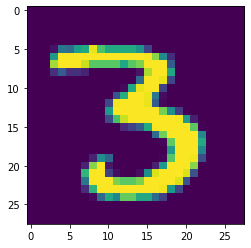

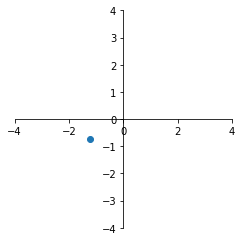

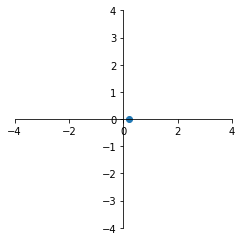

In [4]:
dataset.show_datapoint(12)

# Setting up the Data Object

The *data object* consists of the preprocessed dataset and (optionally) its splits. In order to make use of split validation techniques such as distribution shift between splits, the data splits must be included. 

For the purpose of thsi tutorial, we are going to hold out 20 samples that we are going to use to model "real world" samples that will be encountered at inference time. We will then perform a 60/20/20 split between train, validation, and test sets.

In [5]:
inference_size: int = 20
everything_but_inference_size: int = dataset.__len__() - inference_size
inference_dataset, everything_but_inference_dataset = torch.utils.data.random_split(dataset, [inference_size, dataset.__len__() - inference_size])
    
train_size: int = int(0.6 * len(everything_but_inference_dataset))
val_size: int = int(0.2 * len(everything_but_inference_dataset))
test_size: int = len(everything_but_inference_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(everything_but_inference_dataset, [train_size, val_size, test_size])

data_object: Dict[str, torch.utils.data.Dataset] = {
    "training_set": train_dataset,
    "validation_set": val_dataset,
    "test_set": test_dataset,
    "entire_set": dataset,
    "everything_but_inference_set": everything_but_inference_dataset,
    "inference_set": inference_dataset
}

print(f"size of inference_dataset: {inference_dataset.__len__()}")
print(f"size of everything_but_inference_dataset: {everything_but_inference_dataset.__len__()}")
print(f"size of train_dataset: {train_dataset.__len__()}")
print(f"size of entire dataset: {dataset.__len__()}")
print(f"size of val_dataset: {val_dataset.__len__()}")
print(f"size of test_dataset: {test_dataset.__len__()}")


size of inference_dataset: 20
size of everything_but_inference_dataset: 30
size of train_dataset: 18
size of entire dataset: 50
size of val_dataset: 6
size of test_dataset: 6


# Setting up a Validation Schema

## Specifying Validators and Options

The validation schema contains information about the types of checks that will be executed by the Data Detective Engine and the transforms that Data Detective will use. Before discussing the validation schema, it is important to define two key modular components that make up Data Detective investigations. Data Detective's functionality can be divided into a modular, implementation-heavy component referred to as a *validator method* and an easily toggleable component referred to as a *validator*.

A *validator method* performs a specific type of test for a data issue on a specific data type. These validator methods primarily consist of the code needed to take a dataset and run an evaluation on it that produces either a positive or negative result or a score. Some examples of validator methods include:
- Mann-Whitney U-Test to examine distribution shift between train/test splits on tabular data
- Kernel Conditional Independence (KCI) test for validating causal assumptions on vectorvalued
data
- Isolation forest trained/evaluated on image histograms for identifying anomalies in imaging
data

*Validations* are toggleable, datatype-agnostic collections of validator methods that are serially applied to the dataset. Each validator targets a single problem that may arise in data, including: 
- Shift between different data splits
- Outlier and anomaly detection
- Violation of parametric assumptions on the data
- Violation of expected casual structures / conditional independences in the 

In the validation schema, users only specify the validators that they would like to use. This abstracts away details concerning what methods should be used for which columns and simplifies the process for searching for a particular flavor of issues to a few lines of code. Below is the validation schema that we will use for the tutorial. 

In [6]:
validation_schema : Dict = {
    "default_inclusion": False,
    "validators": {
        "unsupervised_anomaly_data_validator": {},
        "split_covariate_data_validator": {},
        "ood_inference_data_validator": {}
    }
}

A few notes: 
- *default inclusion* referes to whether the validation should include default validators (validators with `is_default` set to `True`)
- Each validator maps to an object that specifies additional options. For this tutorial, we will use the default settings, but these options include: 
  - special kwargs to include and pass to the validator methods
  - additional filtering regarding which columns the validator should be applied to
 
  
  
 

## Specifying Transforms

It may be the case that you are using a data modality that has little to no method infrastructure in Data Detective. The simplest way to make use of all of Data Detective's functionality is to use a transform that maps this data modality to a well-supported modality in Data Detective such as multidimensional data. In our example, we will be making use of a pretrained resnet50 backbone to map our MNIST images to 2048 dimensional vectors. This will allow us to make use of methods built for multidimensional data on our MNIST image representations.

In [7]:
transform_schema : Dict = {
    "transforms": {
        "image": [{
            "name": "resnet50",
            "in_place": "False",
            "options": {},
        }],
    }
}
    
full_validation_schema: Dict = {
    **validation_schema, 
    **transform_schema
}

# Running the Data Detective Engine

Now that the full validation schema and data object are prepared, we are ready to run the Data Detective Engine.

In [8]:
results = validate_from_schema(full_validation_schema, data_object)

running unsupervised_anomaly_data_validator...
   running <class 'src.validator_methods.validator_method_factories.adbench_validator_method_factory.ADBenchValidatorMethodFactory.get_validator_method.<locals>.ADBenchAnomalyValidatorMethod'>...
   running <class 'src.validator_methods.validator_method_factories.adbench_validator_method_factory.ADBenchValidatorMethodFactory.get_validator_method.<locals>.ADBenchAnomalyValidatorMethod'>...
   running <class 'src.validator_methods.validator_method_factories.adbench_validator_method_factory.ADBenchValidatorMethodFactory.get_validator_method.<locals>.ADBenchAnomalyValidatorMethod'>...
running split_covariate_data_validator...
   running <class 'src.validator_methods.kolmogorov_smirnov_split_validator_method.KolmogorovSmirnovSplitValidatorMethod'>...
   running <class 'src.validator_methods.mann_whitney_split_validator_method.MannWhitneySplitValidatorMethod'>...
   running <class 'src.validator_methods.kruskal_wallis_split_validator_method.Krus

In [9]:
results

{'unsupervised_anomaly_data_validator': {'iforest_anomaly_validator_method': {'normal_vector_results': array([ 0.03040916, -0.11641244, -0.08861917, -0.09999748, -0.0173181 ,
          -0.07550594, -0.10695872, -0.07395372, -0.1375773 , -0.12794584,
          -0.14883017, -0.06828945, -0.05739923, -0.11492828, -0.15657678,
          -0.04023962, -0.08988607, -0.07427726,  0.04429047, -0.12870996,
          -0.15094817, -0.16002366, -0.06951095,  0.06698029, -0.11608018,
          -0.11070052, -0.06692922, -0.14622909, -0.15831367, -0.14747675,
          -0.14709245, -0.00215761, -0.0984266 , -0.16049914, -0.14400182,
           0.01941846, -0.15096341, -0.14883702, -0.0637969 , -0.06083675,
           0.08638308, -0.0841963 , -0.14609083, -0.0655864 , -0.13716944,
          -0.0743557 , -0.15537654, -0.01604883, -0.13079909, -0.14949069]),
   'resnet50_backbone_mnist_image_results': array([ 0.01159938, -0.03377824, -0.03026859, -0.00795913, -0.02663643,
          -0.02390393, -0.047322

Great! Let's start to look at and analyze the results we've collected.

# Interpreting Results using the Built-In Rank Aggregator

In [15]:
from enum import Enum

import pandas as pd
import scipy
from typing import List

from pyrankagg.rankagg import FullListRankAggregator

class RankingAggregationMethod(Enum):
    MEDIAN_AGGREGATION = "median_aggregation"
    HIGHEST_RANK = "highest_rank"
    LOWEST_RANK = "lowest_rank"
    STABILITY_SELECTION = "stability_selection"
    EXPONENTIAL_WEIGHTING = "exponential_weighting"
    STABILITY_ENHANCED_BORDA = "stability_enhanced_borda"
    EXPONENTIAL_ENHANCED_BORDA = "exponential_enhanced_borda"
    ROBUST_AGGREGATION = "robust_aggregation"
    ROUND_ROBIN = "round_robin"


class RankingAggregator:
    FLRA = FullListRankAggregator()

    def __init__(self, results_object):
        self.results_object = results_object

    @staticmethod
    def list_is_full_ranking(lst):
        lst_len = len(lst)
        return list(range(lst_len)) == sorted(lst)

    @staticmethod
    def convert_to_scorelist(dataframe):
        """ scorelist = [{'milk':1.4,'cheese':2.6,'eggs':1.2,'bread':3.0},
                         {'milk':2.0,'cheese':3.2,'eggs':2.7,'bread':2.9},
                         {'milk':2.7,'cheese':3.0,'eggs':2.5,'bread':3.5}]"""
        scorelist = []
        for col in dataframe.columns:
            tmp_dict = {f"item {idx}": val for idx, val in zip(dataframe.index, dataframe[col])}
            scorelist.append(tmp_dict)
        return scorelist

    @staticmethod
    def get_rankings(scores):
        return {f"item {k}": v for k, v in RankingAggregator.FLRA.convert_to_ranks(dict(enumerate(scores))).items()}

    def construct_rankings_df(self, validator_name, given_validator_method: str = None, given_data_modality: str = None):
        validator_results = self.results_object[validator_name]
        results_obj = {}

        for validator_method, results_dict in validator_results.items():
            if given_validator_method and (validator_method != given_validator_method):
                continue
            for data_modality, scores in results_dict.items():
                if given_data_modality and (data_modality.replace("_results", "") != given_data_modality):
                    continue
                rankings = RankingAggregator.get_rankings(scores)
                results_obj[f"{data_modality}_{validator_method}_rank"] = rankings
        
        rankings_df = pd.DataFrame(results_obj)
        return rankings_df.sort_index()

    def aggregate_modal_rankings(self, validator_name: str, aggregation_methods: List[RankingAggregationMethod], given_data_modality: str = None, invert=False): 
        rankings_df = self.construct_rankings_df(validator_name, given_data_modality=given_data_modality)
        output_df = rankings_df.copy()
        
        for aggregation_method in aggregation_methods:
            aggregation_method_name = aggregation_method.value
            scorelist = self.convert_to_scorelist(rankings_df)
            agg_method = getattr(RankingAggregator.FLRA, aggregation_method_name)
            agg_rankings = agg_method(scorelist)[1]
            output_df[f"{aggregation_method_name}_agg_rank"] = list(agg_rankings.values())

        return output_df
        
    def aggregate_rankings(self, validator_name: str, aggregation_methods: List[RankingAggregationMethod]):
        rankings_df = self.construct_rankings_df(validator_name)
        output_df = rankings_df.copy()
        
        for aggregation_method in aggregation_methods:
            aggregation_method_name = aggregation_method.value
            scorelist = self.convert_to_scorelist(rankings_df)
            agg_method = getattr(RankingAggregator.FLRA, aggregation_method_name)
            agg_rankings = agg_method(scorelist)[1]

            output_df[f"{aggregation_method_name}_agg_rank"] = list(agg_rankings.values()) 

        return output_df

aggregator = RankingAggregator(results_object=results)
input_df = aggregator.aggregate_modal_rankings("unsupervised_anomaly_data_validator", [RankingAggregationMethod.LOWEST_RANK, RankingAggregationMethod.HIGHEST_RANK, RankingAggregationMethod.ROUND_ROBIN], given_data_modality="normal_vector")
input_df

,normal_vector_results_iforest_anomaly_validator_method_rank,normal_vector_results_cblof_anomaly_validator_method_rank,normal_vector_results_pca_anomaly_validator_method_rank,lowest_rank_agg_rank,highest_rank_agg_rank,round_robin_agg_rank
item 0,4,1,1,1,1,2
item 1,30,11,47,40,19,23
item 10,41,37,36,31,46,46
item 11,15,39,38,27,25,25
item 12,10,32,35,21,17,19
item 13,28,43,29,34,41,34
item 14,47,22,23,41,35,35
item 15,9,15,28,15,15,16
item 16,23,19,41,32,30,29
item 17,18,10,30,16,18,20


5


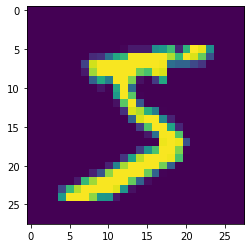

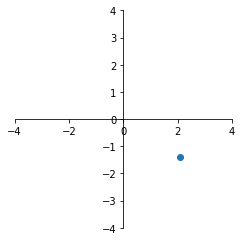

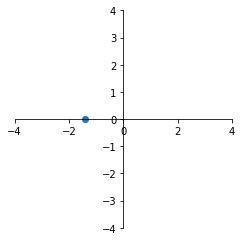

In [17]:
dataset.show_datapoint(0)